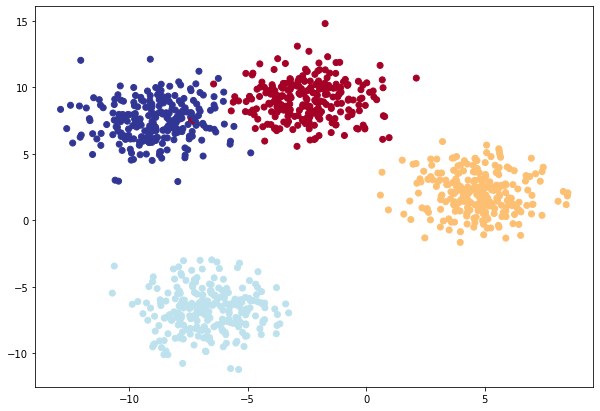

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs 
from sklearn.model_selection import train_test_split
from torch import nn

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class MultiClassification(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.multi_class_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.multi_class_stack(x)

multi_modal = MultiClassification(input_features=2, output_features=8).to(device)

In [10]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = multi_modal.parameters(), lr=0.1)

In [16]:
epochs = 1000

train_loss = []
val_loss = []

for epoch in range(epochs):

  multi_modal.train()

  y_pred = multi_modal(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  multi_modal.eval()

  with torch.inference_mode():
    test_pred = multi_modal(X_test)
    test_loss = loss_fn(test_pred, y_test)
  
  if epoch%10 == 0:
    train_loss.append(loss)
    val_loss.append(test_loss)



In [19]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

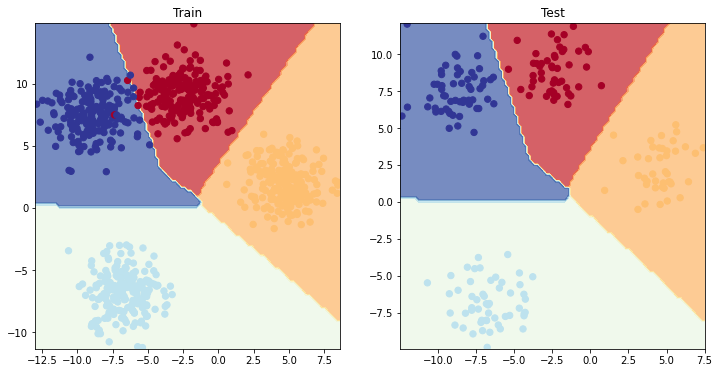

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(multi_modal, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(multi_modal, X_test, y_test)